# Task 2

---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder, StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

In [87]:
df = pd.read_csv("customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [89]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [90]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [91]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5], dtype=int64)

In [92]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.

In [93]:
df

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,6,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,3,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,3,AKLDEL,India,1,0,1,5.52,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2,Internet,RoundTrip,27,6,9,6,PERPNH,Australia,1,0,1,5.62,0
49996,1,Internet,RoundTrip,111,6,4,7,PERPNH,Australia,0,0,0,5.62,0
49997,1,Internet,RoundTrip,24,6,22,6,PERPNH,Australia,0,0,1,5.62,0
49998,1,Internet,RoundTrip,15,6,11,1,PERPNH,Australia,1,0,1,5.62,0


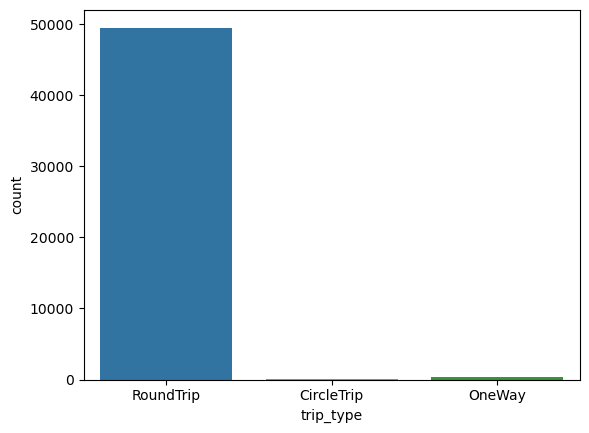

In [94]:
sns.countplot(data=df, x='trip_type')
plt.show()

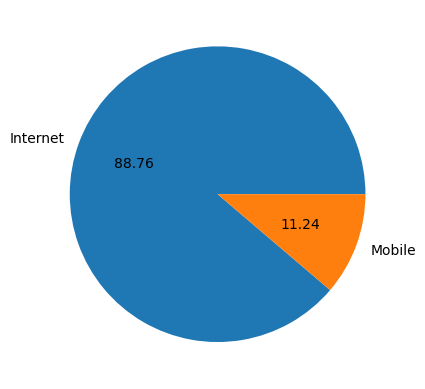

In [95]:
df['sales_channel'].value_counts().plot.pie(autopct='%0.2f')
plt.ylabel("")
plt.show()

In [96]:
df_agg_country = df.groupby('booking_origin').agg(Total_Count=('num_passengers', 'sum')).sort_values('Total_Count', ascending=False).reset_index()
df_agg_country

,booking_origin,Total_Count
0,Australia,25831
1,Malaysia,12025
2,South Korea,7979
3,China,7025
4,Japan,5912
...,...,...
99,Afghanistan,1
100,Norfolk Island,1
101,Pakistan,1
102,Paraguay,1


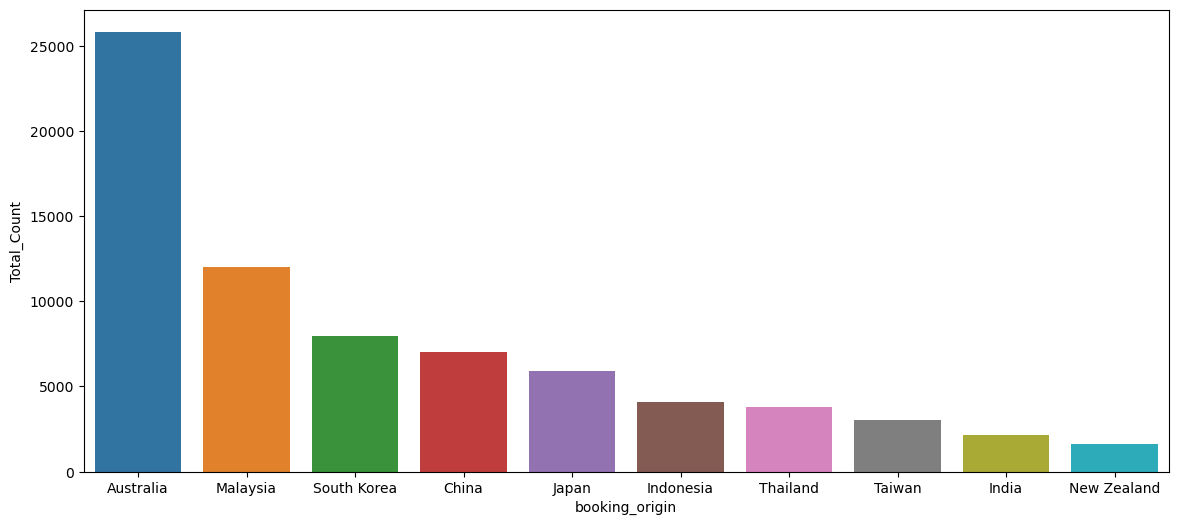

In [97]:
plt.figure(figsize=(14,6))
sns.barplot(data=df_agg_country.head(10), x='booking_origin', y='Total_Count')
plt.show()

<Axes: xlabel='flight_duration', ylabel='Density'>

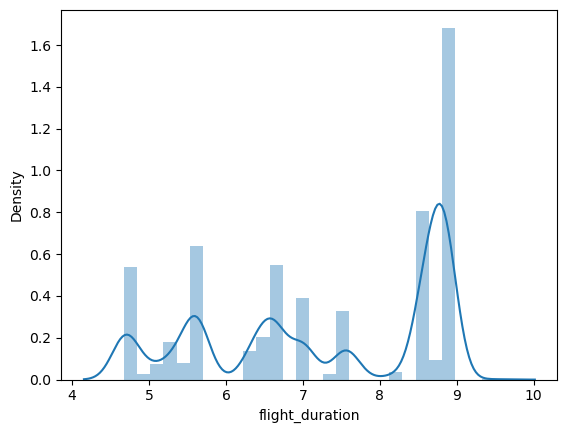

In [98]:
sns.distplot(df['flight_duration'])

---

In [99]:
df

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,6,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,3,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,3,AKLDEL,India,1,0,1,5.52,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2,Internet,RoundTrip,27,6,9,6,PERPNH,Australia,1,0,1,5.62,0
49996,1,Internet,RoundTrip,111,6,4,7,PERPNH,Australia,0,0,0,5.62,0
49997,1,Internet,RoundTrip,24,6,22,6,PERPNH,Australia,0,0,1,5.62,0
49998,1,Internet,RoundTrip,15,6,11,1,PERPNH,Australia,1,0,1,5.62,0


In [100]:
df = df.drop(columns=['route', 'booking_origin'])

In [101]:
df

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,6,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,6,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,3,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,6,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,3,1,0,1,5.52,0
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2,Internet,RoundTrip,27,6,9,6,1,0,1,5.62,0
49996,1,Internet,RoundTrip,111,6,4,7,0,0,0,5.62,0
49997,1,Internet,RoundTrip,24,6,22,6,0,0,1,5.62,0
49998,1,Internet,RoundTrip,15,6,11,1,1,0,1,5.62,0


In [102]:
le = LabelEncoder()
## converting all categorical variables to int
for i in df.columns:
    if df[i].dtype=='object':
        df[i] = le.fit_transform(df[i])

In [103]:
df

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,0,2,262,19,7,6,1,0,0,5.52,0
1,1,0,2,112,20,3,6,0,0,0,5.52,0
2,2,0,2,243,22,17,3,1,1,0,5.52,0
3,1,0,2,96,31,4,6,0,0,1,5.52,0
4,2,0,2,68,22,15,3,1,0,1,5.52,0
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2,0,2,27,6,9,6,1,0,1,5.62,0
49996,1,0,2,111,6,4,7,0,0,0,5.62,0
49997,1,0,2,24,6,22,6,0,0,1,5.62,0
49998,1,0,2,15,6,11,1,1,0,1,5.62,0


In [104]:
df.corr()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
num_passengers,1.000000,-0.002457,0.002261,0.212606,-0.115850,0.015607,0.015407,0.120404,0.028544,0.022943,-0.063169,0.024116
sales_channel,-0.002457,1.000000,0.021237,-0.013399,-0.060352,0.022375,0.042095,-0.054254,0.032943,-0.022235,-0.038629,-0.041060
trip_type,0.002261,0.021237,1.000000,-0.008443,0.006510,-0.002758,-0.001381,-0.014078,0.005668,0.011955,-0.039071,0.027021
purchase_lead,0.212606,-0.013399,-0.008443,1.000000,-0.076560,0.035973,0.036531,-0.022207,-0.004499,-0.022653,0.067866,-0.022131
length_of_stay,-0.115850,-0.060352,0.006510,-0.076560,1.000000,-0.024872,-0.000310,0.176757,0.032264,0.098828,0.141181,-0.042408
flight_hour,0.015607,0.022375,-0.002758,0.035973,-0.024872,1.000000,0.024086,-0.011434,0.012171,0.013014,-0.002101,0.007127
flight_day,0.015407,0.042095,-0.001381,0.036531,-0.000310,0.024086,1.000000,-0.002503,0.005392,0.009281,0.018434,-0.006986
wants_extra_baggage,0.120404,-0.054254,-0.014078,-0.022207,0.176757,-0.011434,-0.002503,1.000000,0.207669,0.216470,0.057054,0.068139
wants_preferred_seat,0.028544,0.032943,0.005668,-0.004499,0.032264,0.012171,0.005392,0.207669,1.000000,0.315088,0.101289,0.050116
wants_in_flight_meals,0.022943,-0.022235,0.011955,-0.022653,0.098828,0.013014,0.009281,0.216470,0.315088,1.000000,0.154312,0.026511


<Axes: >

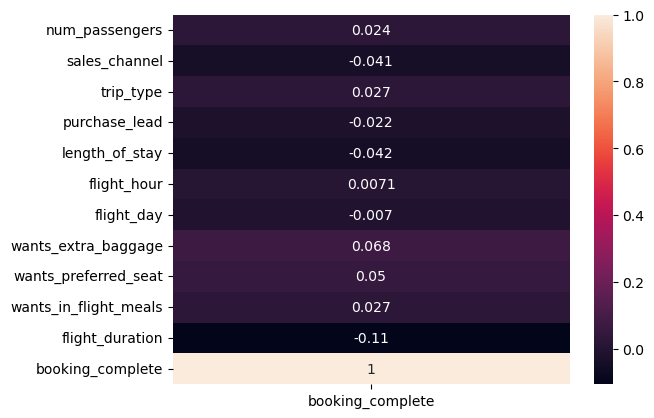

In [105]:
sns.heatmap(df.corr()[['booking_complete']], annot=True)

In [107]:
X = df.drop(columns=['booking_complete'])
y= df['booking_complete']

etf = ExtraTreesClassifier()
etf.fit(X, y)

ExtraTreesClassifier()

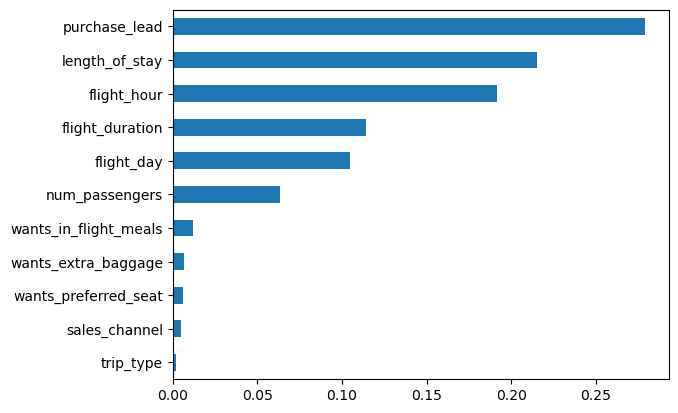

In [113]:
df1 = pd.Series(etf.feature_importances_, index=X.columns)
df1_sorted = df1.nlargest(24)[::-1]  # Reverse the order of the Series
df1_sorted.plot(kind='barh')
plt.show()

In [63]:
# VIF
    # getting columns with non-categorical data and except the dependent column
col_list = []
for col in df.columns:
    if((df[col].dtype!='object') & (col!='booking_complete')):
        col_list.append(col)

    # Returns a dataframe with VIF 
X = df[col_list]
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data)

                  feature        VIF
0          num_passengers   3.704806
1           sales_channel   1.140020
2               trip_type  30.036750
3           purchase_lead   2.003194
4          length_of_stay   1.578098
5             flight_hour   3.779701
6              flight_day   4.630849
7     wants_extra_baggage   3.387493
8    wants_preferred_seat   1.626078
9   wants_in_flight_meals   2.030114
10        flight_duration  23.370776


In [64]:
df.drop(columns=['trip_type'], inplace=True)

In [65]:
# VIF
    # getting columns with non-categorical data and except the dependent column
col_list = []
for col in df.columns:
    if((df[col].dtype!='object') & (col!='booking_complete')):
        col_list.append(col)

    # Returns a dataframe with VIF 
X = df[col_list]
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data)

                 feature       VIF
0         num_passengers  3.461940
1          sales_channel  1.131585
2          purchase_lead  2.002148
3         length_of_stay  1.577430
4            flight_hour  3.534913
5             flight_day  4.283471
6    wants_extra_baggage  3.314661
7   wants_preferred_seat  1.625767
8  wants_in_flight_meals  2.029593
9        flight_duration  9.211598


In [66]:
df.drop(columns=['flight_duration'], inplace=True)

In [67]:
# VIF
    # getting columns with non-categorical data and except the dependent column
col_list = []
for col in df.columns:
    if((df[col].dtype!='object') & (col!='booking_complete')):
        col_list.append(col)

    # Returns a dataframe with VIF 
X = df[col_list]
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data)

                 feature       VIF
0         num_passengers  3.240815
1          sales_channel  1.126995
2          purchase_lead  1.925289
3         length_of_stay  1.496171
4            flight_hour  3.032206
5             flight_day  3.445232
6    wants_extra_baggage  3.134510
7   wants_preferred_seat  1.616771
8  wants_in_flight_meals  1.971962


In [68]:
df

,num_passengers,sales_channel,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,booking_complete
0,2,0,262,19,7,6,1,0,0,0
1,1,0,112,20,3,6,0,0,0,0
2,2,0,243,22,17,3,1,1,0,0
3,1,0,96,31,4,6,0,0,1,0
4,2,0,68,22,15,3,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...
49995,2,0,27,6,9,6,1,0,1,0
49996,1,0,111,6,4,7,0,0,0,0
49997,1,0,24,6,22,6,0,0,1,0
49998,1,0,15,6,11,1,1,0,1,0


<Axes: >

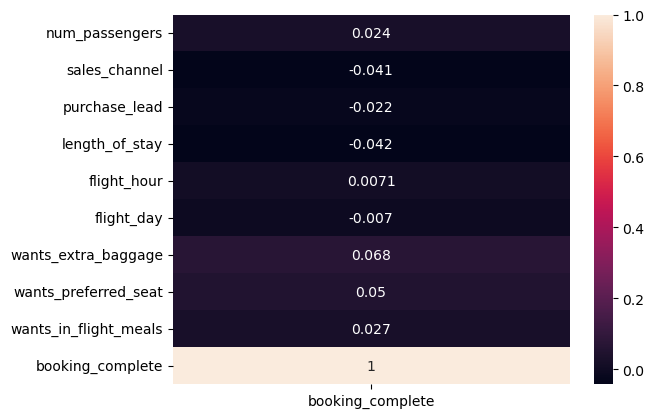

In [85]:
sns.heatmap(df.corr()[['booking_complete']], annot=True)

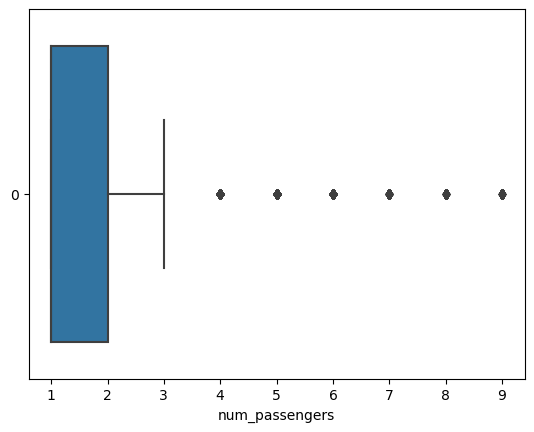

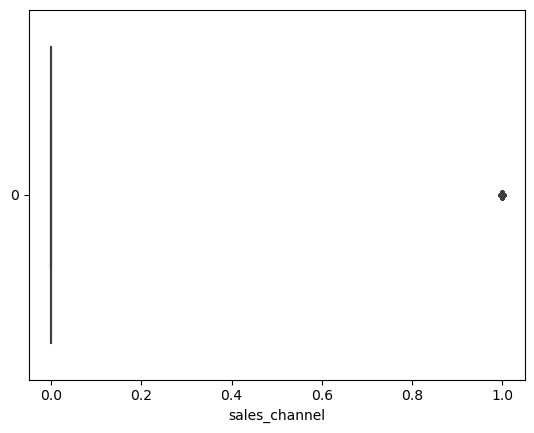

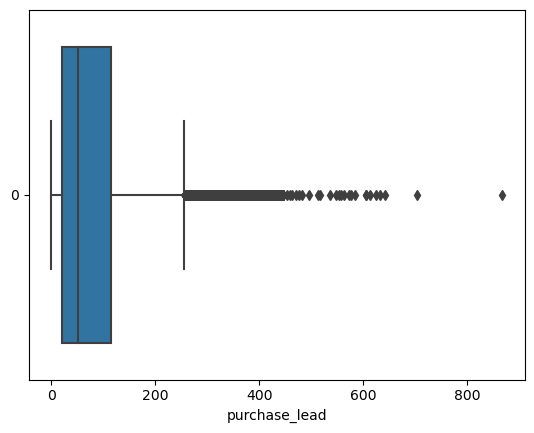

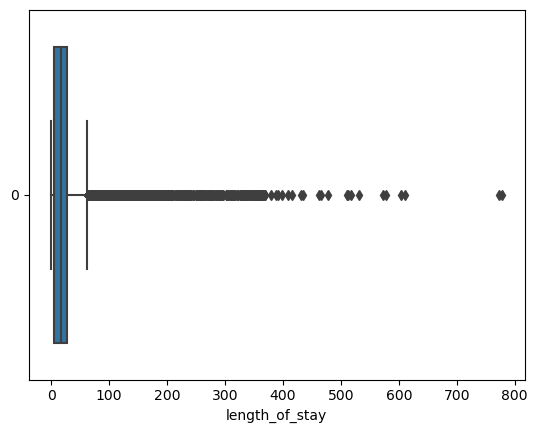

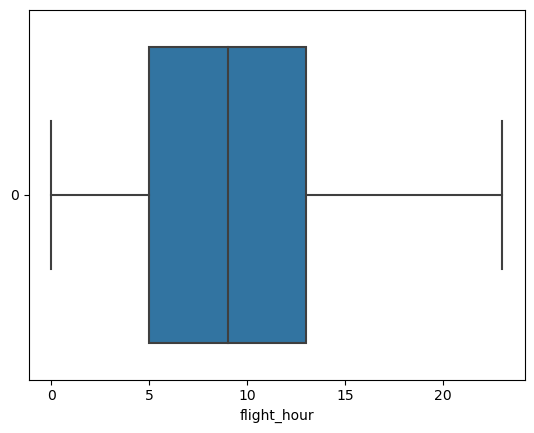

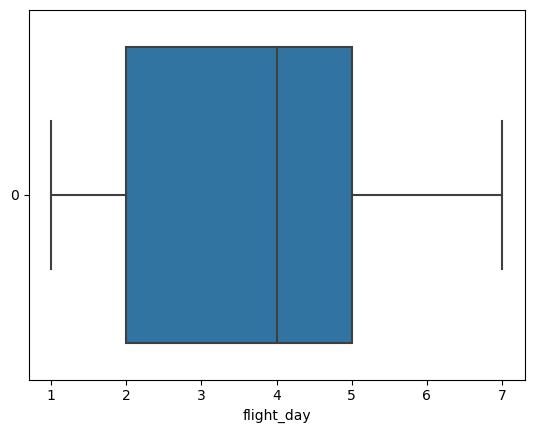

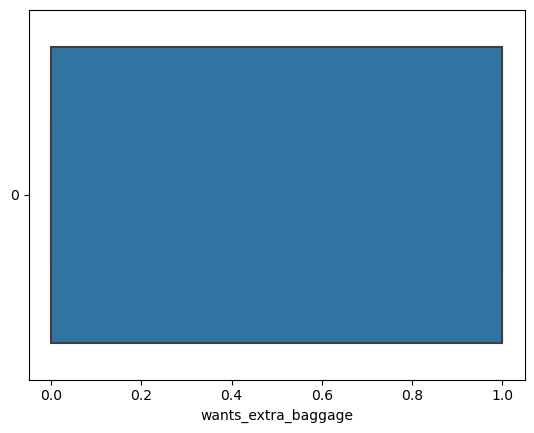

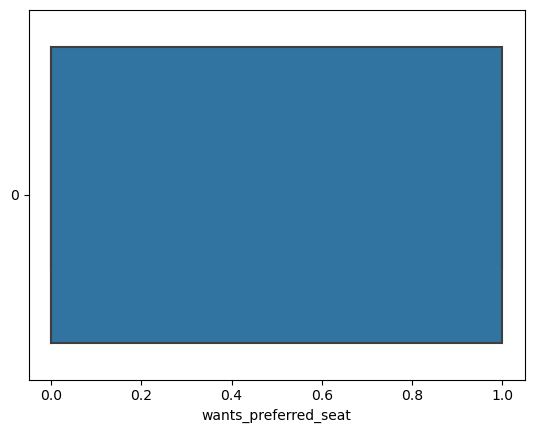

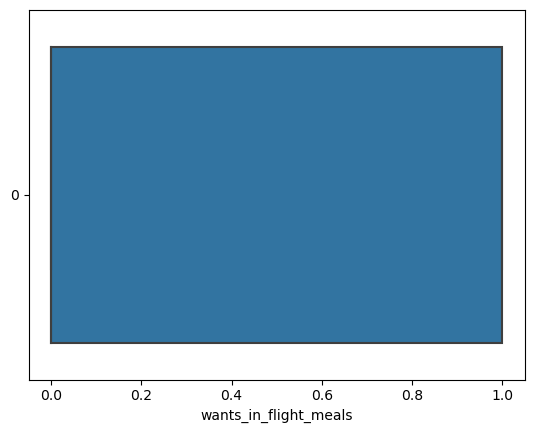

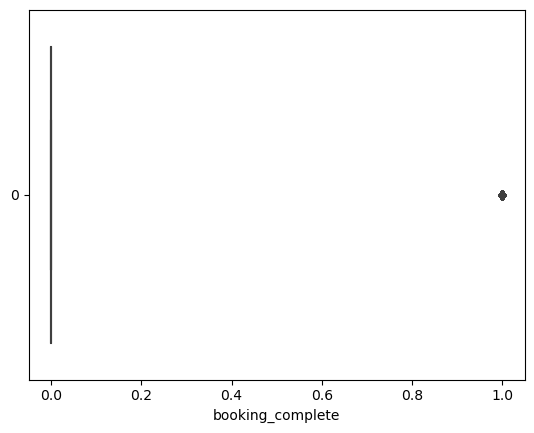

In [69]:
for i in df.columns:
    sns.boxplot(df[i], orient="h")
    plt.xlabel(i)
    plt.show()

# Logistic Regression

In [70]:
X = df.drop(columns=['booking_complete'])
y = df['booking_complete']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=0)

In [71]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [72]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [73]:
y_pred = lr.predict(X_test)

In [74]:
print('Confusion Matrix:\n',confusion_matrix(y_test, y_pred))
print('Accuracy Score ', accuracy_score(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

Confusion Matrix:
 [[8487    0]
 [1513    0]]
Accuracy Score  0.8487
Classification Report:
               precision    recall  f1-score   support

           0       0.85      1.00      0.92      8487
           1       0.00      0.00      0.00      1513

    accuracy                           0.85     10000
   macro avg       0.42      0.50      0.46     10000
weighted avg       0.72      0.85      0.78     10000



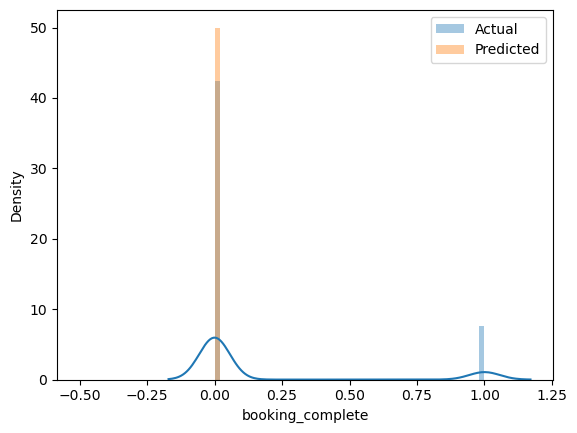

In [75]:
sns.distplot(y_test, label='Actual')
sns.distplot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [76]:
difference = pd.DataFrame(np.c_[y_test, y_pred], columns=['Actual Value', 'Predicted value'])
difference

,Actual Value,Predicted value
0,0,0
1,1,0
2,0,0
3,0,0
4,1,0
...,...,...
9995,0,0
9996,0,0
9997,0,0
9998,0,0


# DT

In [77]:
dec_tree = DecisionTreeClassifier()
dec_tree.fit(X_train,y_train)

DecisionTreeClassifier()

In [78]:
y_pred = dec_tree.predict(X_test)

In [79]:
print('Confusion Matrix:\n',confusion_matrix(y_test, y_pred))
print('Accuracy Score ', accuracy_score(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

Confusion Matrix:
 [[7108 1379]
 [1188  325]]
Accuracy Score  0.7433
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.84      0.85      8487
           1       0.19      0.21      0.20      1513

    accuracy                           0.74     10000
   macro avg       0.52      0.53      0.52     10000
weighted avg       0.76      0.74      0.75     10000



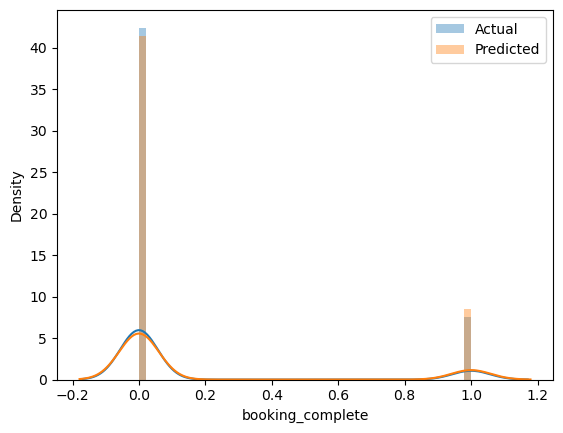

In [80]:
sns.distplot(y_test, label='Actual')
sns.distplot(y_pred, label='Predicted')
plt.legend()
plt.show()

# RF

In [81]:
rand_forest = RandomForestClassifier()
rand_forest.fit(X_train,y_train)

RandomForestClassifier()

In [82]:
y_pred = rand_forest.predict(X_test)

In [83]:
print('Confusion Matrix:\n',confusion_matrix(y_test, y_pred))
print('Accuracy Score ', accuracy_score(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

Confusion Matrix:
 [[8299  188]
 [1419   94]]
Accuracy Score  0.8393
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.98      0.91      8487
           1       0.33      0.06      0.10      1513

    accuracy                           0.84     10000
   macro avg       0.59      0.52      0.51     10000
weighted avg       0.78      0.84      0.79     10000



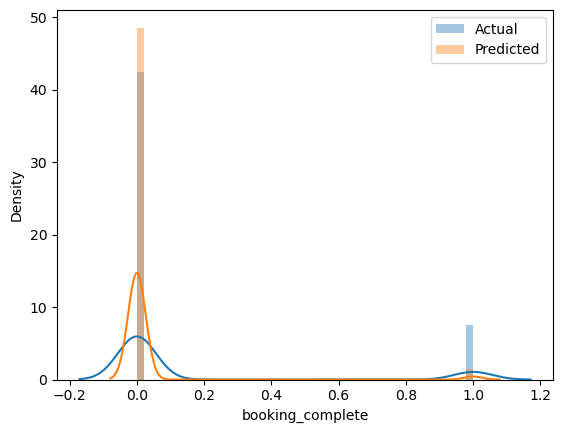

In [84]:
sns.distplot(y_test, label='Actual')
sns.distplot(y_pred, label='Predicted')
plt.legend()
plt.show()